In [1]:
import cProfile
import os
import pstats
import time

import psutil
import torch
import torch.nn as nn
import torch.optim as optim

from panther.nn.attention import RandMultiHeadAttention


In [2]:
def profile(func, *args):
    with cProfile.Profile() as pr:
        rets = func(*args)
    results = pstats.Stats(pr).sort_stats(pstats.SortKey.TIME)
    results.print_stats()
    return rets

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


# Sample synthetic dataset (sequence classification)
def generate_data(num_samples=100, seq_len=3000, dim=32, num_classes=2):
    X = torch.randn(num_samples, seq_len, dim, device=device)  # Random embeddings
    y = torch.randint(0, num_classes, (num_samples,), device=device)  # Random labels
    return X, y


def get_cpu_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss  # in bytes


# Define a simple Transformer-like model with custom Multihead Attention
class CustomTransformer(nn.Module):
    def __init__(self, embed_dim, num_heads, num_classes, num_rand_features=None):
        super().__init__()
        if num_rand_features is None:
            self.attention = nn.MultiheadAttention(
                embed_dim, num_heads, batch_first=True
            )
        else:
            self.attention = RandMultiHeadAttention(
                embed_dim,
                num_heads,
                num_random_features=num_rand_features,
                kernel_fn="softmax",
            )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.attention(x, x.clone(), x.clone())[0]  # Multihead Attention
        x = x.mean(dim=1)  # Pooling
        return self.fc(x)


def train_model(model, X_train, y_train, epochs=5, lr=1e-3):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()
    start_time = time.time()

    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats(device)
    else:
        mem_before = get_cpu_memory_usage()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    training_time = time.time() - start_time

    if device.type == "cuda":
        mem_usage = torch.cuda.max_memory_allocated(device)
    else:
        mem_usage = get_cpu_memory_usage() - mem_before

    return loss.item(), training_time, mem_usage


# Forward pass benchmarking
def measure_forward_pass(model, X):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        if device.type == "cuda":
            torch.cuda.reset_peak_memory_stats(device)
            torch.cuda.synchronize()
        else:
            mem_before = get_cpu_memory_usage()

        start_time = time.time()
        _ = model(X)
        if device.type == "cuda":
            torch.cuda.synchronize()
        forward_time = time.time() - start_time

        if device.type == "cuda":
            mem_usage = torch.cuda.max_memory_allocated(device)
        else:
            mem_usage = get_cpu_memory_usage() - mem_before

    return forward_time, mem_usage


def measure_accuracy(model, X, y_true):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(X)

        if outputs.shape[-1] == 1:  # Binary classification
            preds = (outputs > 0.5).long().squeeze()
        else:  # Multiclass classification
            preds = outputs.argmax(dim=1)

        accuracy = (preds == y_true).float().mean().item()

    return accuracy


# Hyperparameters
embed_dim = 32
num_heads = 4
num_classes = 2


# Generate synthetic dataset
def fun(s):
    X_train, y_train = generate_data(seq_len=s)

    # Initialize models
    custom_attention_model = CustomTransformer(
        embed_dim, num_heads, num_classes, num_rand_features=128
    )
    torch_attention_model = CustomTransformer(embed_dim, num_heads, num_classes)
    # Compare models
    # torch_loss, torch_time, torch_mem = profile(
    #     train_model, torch_attention_model, X_train, y_train
    # )
    # print("---------------------------------------------------")
    # custom_loss, custom_time, custom_mem = profile(
    #     train_model, custom_attention_model, X_train, y_train
    # )
    # print("---------------------------------------------------")
    torch_loss, torch_time, torch_mem = train_model(
        torch_attention_model, X_train, y_train
    )
    custom_loss, custom_time, custom_mem = train_model(
        custom_attention_model, X_train, y_train
    )
    custom_forward_time, custom_forward_mem = measure_forward_pass(
        custom_attention_model, X_train
    )
    torch_forward_time, torch_forward_mem = measure_forward_pass(
        torch_attention_model, X_train
    )
    # Print results
    print(
        f"Custom Attention - Loss: {custom_loss:.4f}, Time: {custom_time:.4f}s, Memory: {custom_mem / 1024:.2f} KB,Memory per length: {custom_mem / 1024 / s:.2f} KB"
    )
    print(
        f"Torch Attention - Loss: {torch_loss:.4f}, Time: {torch_time:.4f}s, Memory: {torch_mem / 1024:.2f} KB,Memory per length: {torch_mem / 1024 / s:.2f} KB"
    )
    print(
        f"Custom Attention - Forward Time: {custom_forward_time:.4f}s, Forward Memory: {custom_forward_mem / 1024:.2f} KB,Memory per length: {custom_forward_mem / 1024 / s:.2f} KB"
    )
    print(
        f"Torch Attention - Forward Time: {torch_forward_time:.4f}s, Forward Memory: {torch_forward_mem / 1024:.2f} KB,Memory per length: {torch_forward_mem / 1024 / s:.2f} KB"
    )


In [4]:
from panther.nn.attention import make_performer


def fun2(s):
    results = []

    X_train, y_train = generate_data(seq_len=s)
    torch_attention_model = CustomTransformer(embed_dim, num_heads, num_classes)
    torch_loss, torch_time, torch_mem = train_model(
        torch_attention_model, X_train, y_train
    )
    torch_acc = measure_accuracy(torch_attention_model, X_train, y_train)
    print(f"[s={s}] Torch Attention - Accuracy: {torch_acc:.4f}")

    for j in [64, 128, 256, 512, 1024]:
        print(f"Num Random Features: {j}")
        custom_attention_model = CustomTransformer(
            embed_dim, num_heads, num_classes, num_rand_features=j
        )
        custom_attention_model.fc = torch_attention_model.fc
        custom_attention_model.attention = make_performer(
            torch_attention_model.attention,
            num_random_features=j,
            kernel_fn="softmax",
            iscausal=False,
        )
        custom_acc = measure_accuracy(custom_attention_model, X_train, y_train)
        print(f"Custom Attention - Accuracy: {custom_acc:.4f}")
        results.append((j, custom_acc))

    return torch_acc, results  # base model accuracy and list of (num_features, acc)


[s=10] Torch Attention - Accuracy: 0.6100
Num Random Features: 64
Custom Attention - Accuracy: 0.6200
Num Random Features: 128
Custom Attention - Accuracy: 0.6300
Num Random Features: 256
Custom Attention - Accuracy: 0.6100
Num Random Features: 512
Custom Attention - Accuracy: 0.6200
Num Random Features: 1024
Custom Attention - Accuracy: 0.5900
[s=100] Torch Attention - Accuracy: 0.5200
Num Random Features: 64
Custom Attention - Accuracy: 0.5200
Num Random Features: 128
Custom Attention - Accuracy: 0.5200
Num Random Features: 256
Custom Attention - Accuracy: 0.5200
Num Random Features: 512
Custom Attention - Accuracy: 0.5200
Num Random Features: 1024
Custom Attention - Accuracy: 0.5200
[s=1000] Torch Attention - Accuracy: 0.5800
Num Random Features: 64
Custom Attention - Accuracy: 0.5800
Num Random Features: 128
Custom Attention - Accuracy: 0.5800
Num Random Features: 256
Custom Attention - Accuracy: 0.5800
Num Random Features: 512
Custom Attention - Accuracy: 0.5800
Num Random Feature

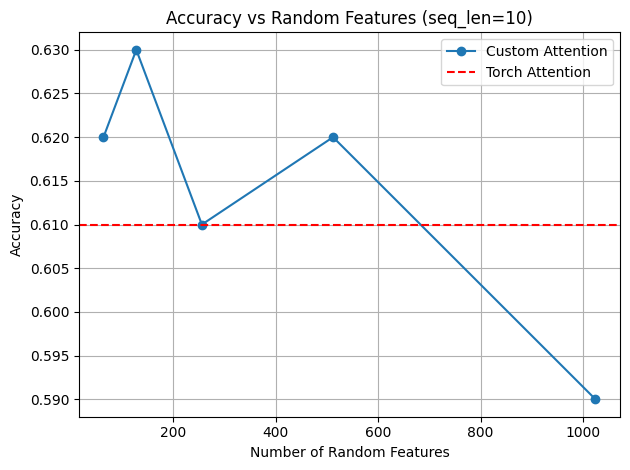

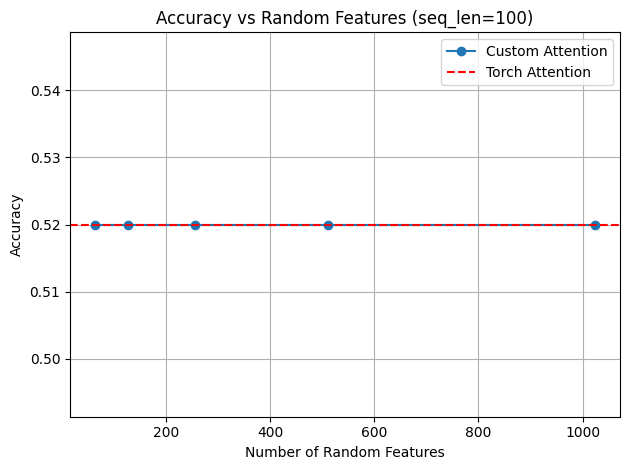

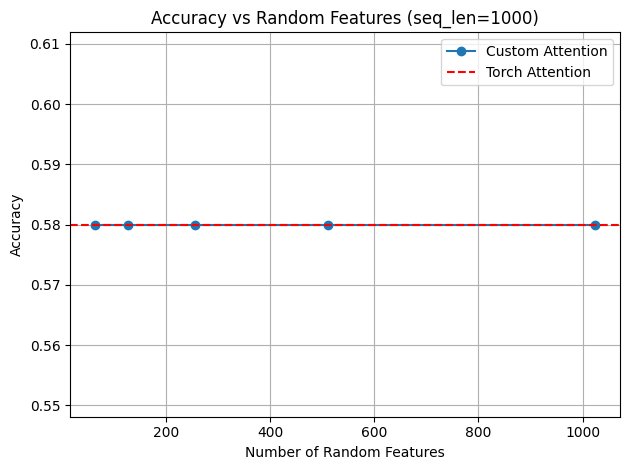

In [5]:
import matplotlib.pyplot as plt

sequence_lengths = [10, 100, 1000]
all_results = {}

for s in sequence_lengths:
    torch_acc, custom_results = fun2(s)
    all_results[s] = {
        "torch": torch_acc,
        "custom": custom_results,
    }

# Plotting
for s in sequence_lengths:
    custom_results = all_results[s]["custom"]
    torch_acc = all_results[s]["torch"]

    j_vals = [j for j, _ in custom_results]
    acc_vals = [acc for _, acc in custom_results]

    plt.figure()
    plt.plot(j_vals, acc_vals, marker="o", label="Custom Attention")
    plt.axhline(y=torch_acc, color="r", linestyle="--", label="Torch Attention")
    plt.title(f"Accuracy vs Random Features (seq_len={s})")
    plt.xlabel("Number of Random Features")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
